In [1]:
import shutil
import errno
import zipfile
import os
import matplotlib.pyplot as plt

In [4]:
# Only run once to unzip images
zip_ref = zipfile.ZipFile('D:/fa20/CAP6610-ML/29561_37705_bundle_archive.zip','r')
zip_ref.extractall()
zip_ref.close()

Create a custom image generator

In [5]:
# data generator
# source from https://medium.com/@ensembledme/writing-custom-keras-generators-fe815d992c5a
from skimage.io import imread

def get_input(path):
    """get specific image from path"""
    img = imread(path)
    return img

def get_output(path, label_file = None):
    """get all the labels relative to the image of path"""
    img_id = path.split('/')[-1]
    labels = label_file.loc[img_id].values
    return labels

def preprocess_input(img):
    # convert between 0 and 1
    return img.astype('float32') / 127.5 -1

def image_generator(files, label_file, batch_size = 32):
    while True:

        batch_paths = np.random.choice(a = files, size = batch_size)
        batch_input = []
        batch_output = []

        for input_path in batch_paths:

            input = get_input(input_path)
            input = preprocess_input(input)
            output = get_output(input_path, label_file = label_file)
            batch_input += [input]
            batch_output += [output]
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        yield batch_x, batch_y

def auto_encoder_generator(files, batch_size = 32):
    while True:
        batch_paths = np.random.choice(a = files, size = batch_size)
        batch_input = []
        batch_output = []

        for input_path in batch_paths:
            input = get_input(input_path)
            input = preprocess_input(input)
            output = input
            batch_input += [input]
            batch_output += [output]
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        yield batch_x, batch_y

In [6]:
import pandas as pd
attr = pd.read_csv('list_attr_celeba.csv')
attr = attr.set_index('image_id')

# check if attribute successful loaded
attr.describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,...,202599.000000,202599.000000,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,-0.777728,-0.466039,0.02501,-0.590857,-0.955113,-0.696849,-0.518408,-0.530935,-0.521498,-0.704016,...,-0.886979,-0.035839,-0.583196,-0.360866,-0.62215,-0.903079,-0.055129,-0.754066,-0.854570,0.547234
std,0.628602,0.884766,0.99969,0.806778,0.296241,0.717219,0.855135,0.847414,0.853255,0.710186,...,0.461811,0.999360,0.812333,0.932620,0.78290,0.429475,0.998482,0.656800,0.519338,0.836982
min,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
50%,-1.000000,-1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
75%,-1.000000,1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,1.000000,-1.000000,1.000000,-1.00000,-1.000000,1.000000,-1.000000,-1.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


Finish making the generator.

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

IMG_NAME_LENGTH = 6

file_path = "img_align_celeba/img_align_celeba/"
img_id = np.arange(1,len(attr.index)+1)
img_path = []
for i in range(len(img_id)):
    img_path.append(file_path + (IMG_NAME_LENGTH - len(str(img_id[i])))*'0' + str(img_id[i]) + '.jpg')

# pick 80% as training set and 20% as validation set
train_path = img_path[:int((0.8)*len(img_path))]
val_path = img_path[int((0.8)*len(img_path)):]

train_generator = auto_encoder_generator(train_path,32)
val_generator = auto_encoder_generator(val_path,32)

Pick three images and check that attributes make sense.

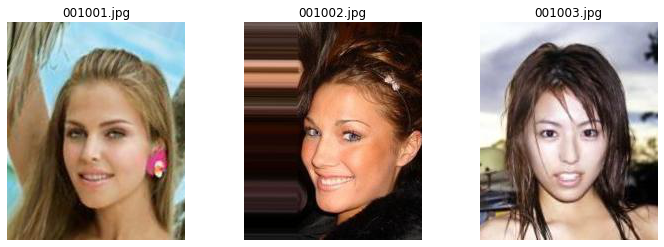

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1


In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):    
    ax[i].imshow(get_input(img_path[i+1000]))
    ax[i].axis('off')
    ax[i].set_title(img_path[i+1000][-10:])
plt.show()
    
attr.iloc[:3]

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy

Using TensorFlow backend.
D:\anaconda3\envs\ML3614\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda3\envs\ML3614\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda3\envs\ML3614\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda3\envs\ML3614\lib\site-packages\tensorflow\python\framework\dtypes.py

In [14]:
img_sample = get_input(img_path[0])
img_sample.shape

(218, 178, 3)

In [15]:
b_size = 128
n_size = 512
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape = (n_size,) , mean = 0, stddev = 1)
    return z_mean + K.exp(z_log_sigma/2) * epsilon
  
def build_conv_vae(input_shape, bottleneck_size, sampling, batch_size = 32):
    
    # ENCODER
    input = Input(shape=(input_shape[0],input_shape[1],input_shape[2]))
    x = Conv2D(32,(3,3),activation = 'relu', padding = 'same')(input)    
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    x = Conv2D(64,(3,3),activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    x = Conv2D(128,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    x = Conv2D(256,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    
    # Latent Variable Calculation
    shape = K.int_shape(x)
    flatten_1 = Flatten()(x)
    dense_1 = Dense(bottleneck_size, name='z_mean')(flatten_1)
    z_mean = BatchNormalization()(dense_1)
    flatten_2 = Flatten()(x)
    dense_2 = Dense(bottleneck_size, name ='z_log_sigma')(flatten_2)
    z_log_sigma = BatchNormalization()(dense_2)
    z = Lambda(sampling)([z_mean, z_log_sigma])
    encoder = Model(input, [z_mean, z_log_sigma, z], name = 'encoder')
    
    # DECODER
    latent_input = Input(shape=(bottleneck_size,), name = 'decoder_input')
    x = Dense(shape[1]*shape[2]*shape[3])(latent_input)
    x = Reshape((shape[1],shape[2],shape[3]))(x)
    x = UpSampling2D((2,2))(x)
    x = Cropping2D([[0,0],[0,1]])(x)
    x = Conv2DTranspose(256,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    x = Cropping2D([[0,1],[0,1]])(x)
    x = Conv2DTranspose(128,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    x = Cropping2D([[0,1],[0,1]])(x)
    x = Conv2DTranspose(64,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    output = Conv2DTranspose(3,(3,3), activation = 'tanh', padding ='same')(x)
    decoder = Model(latent_input, output, name = 'decoder')

    output_2 = decoder(encoder(input)[2])
    vae = Model(input, output_2, name ='vae')
    return vae, encoder, decoder, z_mean, z_log_sigma

vae_2, encoder, decoder, z_mean, z_log_sigma = build_conv_vae(img_sample.shape, n_size, sampling, batch_size = b_size)
print("encoder summary:")
encoder.summary()
print("decoder summary:")
decoder.summary()
print("vae summary:")
vae_2.summary()









encoder summary:
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 218, 178, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 218, 178, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 218, 178, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 109, 89, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________

In [16]:
def vae_loss(input_img, output):
    # Compute error in reconstruction
    reconstruction_loss = mse(K.flatten(input_img) , K.flatten(output))
    
    # Compute the KL Divergence regularization term
    kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = -1)
    
    # Return the average loss over all images in batch
    total_loss = (reconstruction_loss + 0.0001 * kl_loss)    
    return total_loss

In [17]:
vae_2.compile(optimizer='rmsprop', loss= vae_loss)
encoder.compile(optimizer = 'rmsprop', loss = vae_loss)
decoder.compile(optimizer = 'rmsprop', loss = vae_loss)

In [18]:
vae_2.fit_generator(train_generator, steps_per_epoch = 4000, validation_data = val_generator, epochs=15, validation_steps= 500)

Epoch 1/15
4000/4000 [==============================] - 941s 235ms/step - loss: 0.0956 - val_loss: 0.0814
Epoch 2/15
4000/4000 [==============================] - 938s 235ms/step - loss: 0.0741 - val_loss: 0.0706
Epoch 3/15
4000/4000 [==============================] - 956s 239ms/step - loss: 0.0697 - val_loss: 0.0688
Epoch 4/15
4000/4000 [==============================] - 933s 233ms/step - loss: 0.0669 - val_loss: 0.0690
Epoch 5/15
4000/4000 [==============================] - 953s 238ms/step - loss: 0.0649 - val_loss: 0.0689
Epoch 6/15
4000/4000 [==============================] - 930s 233ms/step - loss: 0.0632 - val_loss: 0.0680
Epoch 7/15
4000/4000 [==============================] - 929s 232ms/step - loss: 0.0622 - val_loss: 0.0695
Epoch 8/15
4000/4000 [==============================] - 934s 234ms/step - loss: 0.0610 - val_loss: 0.0696
Epoch 9/15
4000/4000 [==============================] - 978s 244ms/step - loss: 0.0602 - val_loss: 0.0702
Epoch 10/15
4000/4000 [=======================

We randomly choose some images of the training set, run them through the encoder to parameterize the latent code, and then reconstruct the images with the decoder.

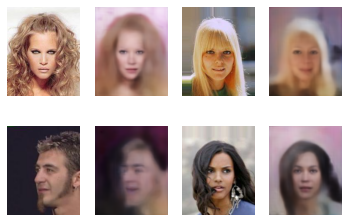

In [19]:
import random
x_test = []
for i in range(64):
    x_test.append(get_input(img_path[random.randint(0,len(img_id))]))
x_test = np.array(x_test)
figure_Decoded = vae_2.predict(x_test.astype('float32')/127.5 -1, batch_size = b_size)
figure_original = x_test[0]
figure_decoded = (figure_Decoded[0]+1)/2
for i in range(4):
    plt.axis('off')
    plt.subplot(2,4,1+i*2)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.subplot(2,4,2 + i*2)
    plt.imshow((figure_Decoded[i]+1)/2)
    plt.axis('off')
plt.show()

Notice that the reconstructed images share similarities with the original versions. However, the new images are a bit blurry, which is a known phenomenon of VAEs. This has been hypothesized to be due to the fact that variational inference optimizes a lower bound to the likelihood, not the actual likelihood itself.

We choose two images with different attributes and plot their latent space representations. Notice that we can see some differences between the latent codes, which we might hypothesize as explaining the differences between the original images.

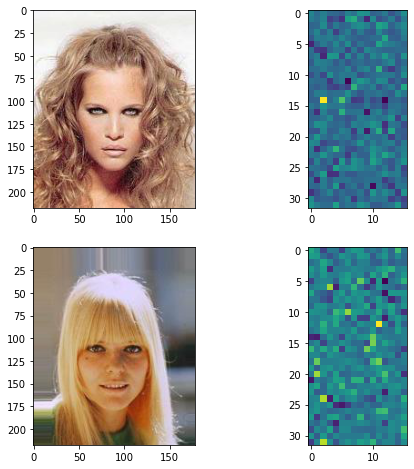

In [39]:
# Choose two images of different attributes, and plot the original and latent space of it

x_test1 = []
for i in range(64):
    x_test1.append(get_input(img_path[np.random.randint(0,len(img_id))]))
x_test1 = np.array(x_test)
x_test_encoded = np.array(encoder.predict(x_test1/127.5-1, batch_size = b_size))
figure_original_1 = x_test[0]
figure_original_2 = x_test[1]
Encoded1 = (x_test_encoded[0,0,:].reshape(32, 16,)+1)/2 
Encoded2 = (x_test_encoded[0,1,:].reshape(32, 16)+1)/2

plt.figure(figsize=(8, 8))
plt.subplot(2,2,1)
plt.imshow(figure_original_1)
plt.subplot(2,2,2)
plt.imshow(Encoded1)
plt.subplot(2,2,3)
plt.imshow(figure_original_2)
plt.subplot(2,2,4)
plt.imshow(Encoded2)
plt.show()

We randomly sample 15 latent codes and decode them to generate new celebrity faces. We can see from this representation that the images generated by our model are of similar styles with the training images, they are also realistic and have a good variation, meaning we are not suffering from modal collapse.

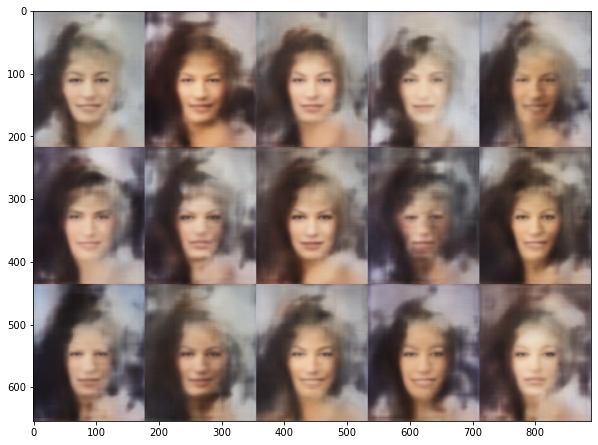

In [38]:
# We randomly generated 15 images from 15 series of noise information

n = 3
m = 5
digit_size1 = 218
digit_size2 = 178
figure = np.zeros((digit_size1 * n, digit_size2 * m,3))
 
for i in range(3):
    for j in range(5):
        z_sample = np.random.rand(1,512)
        x_decoded = decoder.predict([z_sample])
        figure[i * digit_size1: (i + 1) * digit_size1,
               j * digit_size2: (j + 1) * digit_size2,:] = (x_decoded[0]+1)/2 

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()